#  Tesla Stock Prediction with Sentiment Analysis

본 프로젝트는 테슬라(Tesla)의 주가 예측을 위해 뉴스 데이터를 기반으로 감성 분석(sentiment analysis)을 수행하고,  
이를 활용한 시계열 예측 모델(LSTM)을 통해 주가 흐름을 분석하는 데이터 기반 투자 인사이트 프로젝트입니다.

---

## 🔍 목적
- 뉴스 헤드라인을 통해 투자 심리를 정량화하고,
- 다양한 감성 분석 모델(VADER, FinBERT, OpenAI GPT, KR-FinBert)의 비교를 통해,
- 실제 주가와 감성 점수 간의 관계를 분석하며,
- LSTM을 통해 향후 주가 예측 가능성을 탐색합니다.

---

## 🧰 사용한 기술
- 감성 분석: VADER, FinBERT, OpenAI GPT, KR-FinBert
- 시계열 예측: LSTM (TensorFlow 기반)
- 시각화 및 분석: matplotlib, seaborn, pandas

# I. 주식 시장 가격 예측

## 1. 데이터 로드 및 기술적 지표 추가

In [18]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 📌 1. 테슬라(TSLA) 주가 데이터 가져오기
ticker = "TSLA"
df = yf.download(ticker, start="2024-12-11", end="2025-03-22")

# 📌 2. 기술적 지표 추가
df["MA_10"] = df["Close"].rolling(window=10).mean()  # 10일 이동평균
df["MA_50"] = df["Close"].rolling(window=50).mean()  # 50일 이동평균
df["Volatility"] = df["Close"].pct_change().rolling(window=10).std()  # 변동성

# MACD 계산
df["EMA_12"] = df["Close"].ewm(span=12, adjust=False).mean()
df["EMA_26"] = df["Close"].ewm(span=26, adjust=False).mean()
df["MACD"] = df["EMA_12"] - df["EMA_26"]

# 볼린저 밴드 계산
df["Rolling_STD"] = df["Close"].rolling(window=10).std()  # 표준편차 계산 후 별도 저장
df["Upper_Band"] = df["MA_10"] + (df["Rolling_STD"].values.flatten() * 2)
df["Lower_Band"] = df["MA_10"] - (df["Rolling_STD"].values.flatten() * 2)

# 거래량을 로그 스케일로 변환
df["Volume_log"] = np.log(df["Volume"] + 1)

# 결측값 제거
df.dropna(inplace=True)

# 특성 선택
features = ["MA_10", "MA_50", "Volatility", "MACD", "Upper_Band", "Lower_Band", "Volume_log"]
X = df[features]
y = df["Close"]

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("✅ 데이터 준비 완료")

[*********************100%***********************]  1 of 1 completed

✅ 데이터 준비 완료


## 2. Random Forest & XGBoost 모델 적용

/Users/naeun/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


📌 Random Forest RMSE: 9.99, R² Score: -0.4515
📌 XGBoost RMSE: 9.73, R² Score: -0.3794


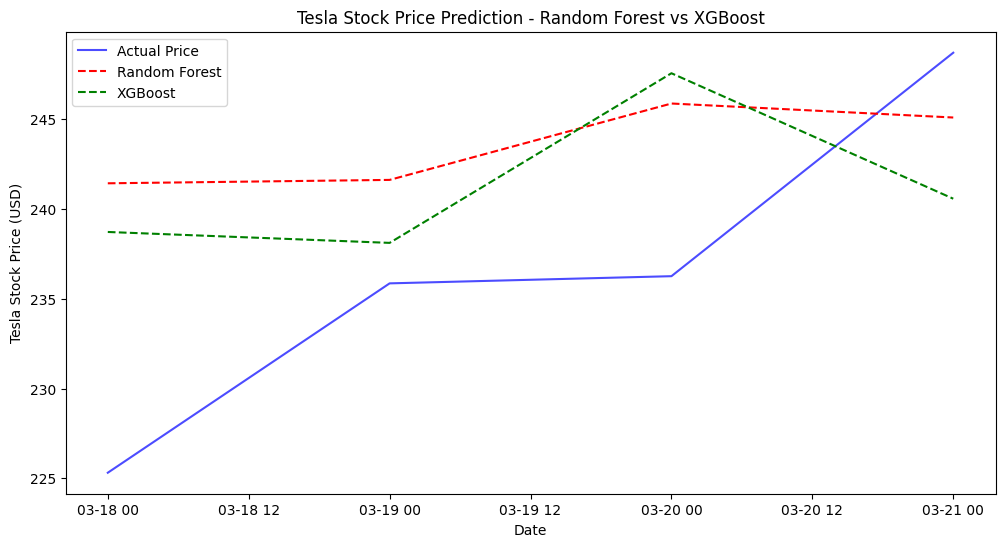

In [19]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# 📌 최적 파라미터: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

# 📌 랜덤 포레스트 모델
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=10,min_samples_split=5 )
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# 📌 XGBoost 모델
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# 📌 성능 평가
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"📌 {model_name} RMSE: {rmse:.2f}, R² Score: {r2:.4f}")

evaluate_model(y_test, rf_pred, "Random Forest")
evaluate_model(y_test, xgb_pred, "XGBoost")

# 📌 예측 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Price", color="blue", alpha=0.7)
plt.plot(y_test.index, rf_pred, label="Random Forest", color="red", linestyle="dashed")
plt.plot(y_test.index, xgb_pred, label="XGBoost", color="green", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Tesla Stock Price (USD)")
plt.title("Tesla Stock Price Prediction - Random Forest vs XGBoost")
plt.legend()
plt.show()

## 3. LSTM (딥러닝) 적용

/Users/naeun/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,851 (124.42 KB)

 Trainable params: 31,851 (124.42 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.1496 - val_loss: 0.0805
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0727 - val_loss: 0.0516
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0407 - val_loss: 0.0311
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0162 - val_loss: 0.0181
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0097 - val_loss: 0.0115
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0125 - val_loss: 0.0088
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0312 - val_loss: 0.0083
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0304 - val_loss: 0.0085
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0326 - val_loss: 0.0092
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0298 - val_loss: 0.0104
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0216 - val_loss: 0.0125
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0180 - val_loss: 0.0154
E

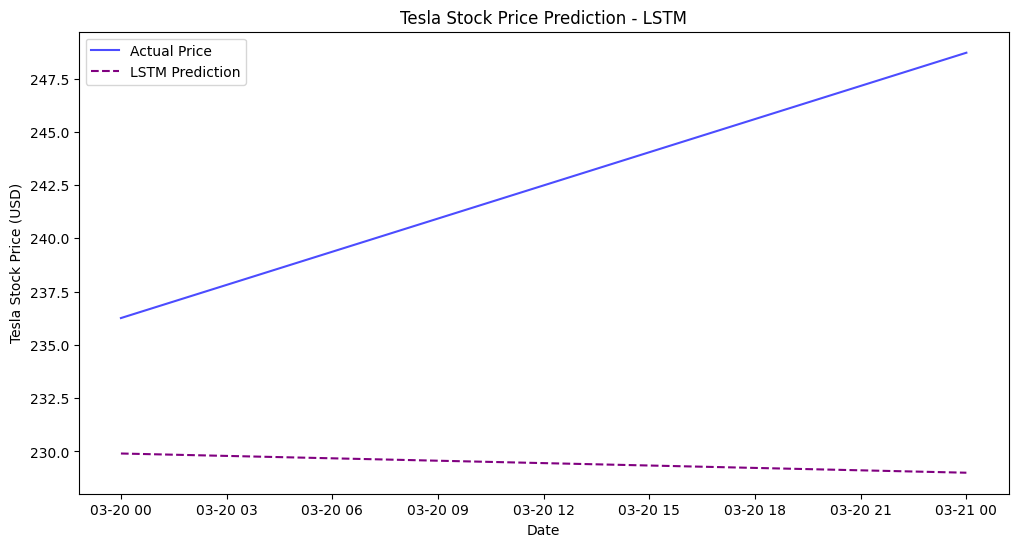

In [20]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 📌 데이터 스케일링
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# 📌 시퀀스 데이터 생성 (LSTM 입력 형태: (samples, time steps, features))
def create_sequences(data, target, window_size):
    Xs, ys = [], []
    for i in range(len(data) - window_size):
        Xs.append(data[i : i + window_size])
        ys.append(target[i + window_size])
    return np.array(Xs), np.array(ys)

window_size = 10  # 10일 단위 시퀀스
X_lstm, y_lstm = create_sequences(X_scaled, y_scaled, window_size)

# 📌 훈련/테스트 분할
split = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]

# 📌 LSTM 모델 구축
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()

# 📌 모델 훈련
history = model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=16, validation_data=(X_test_lstm, y_test_lstm), verbose=1)

# 📌 예측
y_pred_lstm = model.predict(X_test_lstm)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

# 📌 LSTM 예측 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test.index[-len(y_pred_lstm):], y_test[-len(y_pred_lstm):], label="Actual Price", color="blue", alpha=0.7)
plt.plot(y_test.index[-len(y_pred_lstm):], y_pred_lstm, label="LSTM Prediction", color="purple", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Tesla Stock Price (USD)")
plt.title("Tesla Stock Price Prediction - LSTM")
plt.legend()
plt.show()

## 4. GridSearchCV를 활용한 Hyperparameter Tuning

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring="neg_mean_squared_error", verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"📌 최적 파라미터: {grid_search.best_params_}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/naeun/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/naeun/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/naeun/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/naeun/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector 

📌 최적 파라미터: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


/Users/naeun/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


# II. ChatGPT 기반 뉴스 헤드라인 감성분석

In [22]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import time

def get_naver_news(keyword, days=30, max_pages=3):
    """ 네이버 뉴스에서 특정 키워드(예: 테슬라)로 30일치 뉴스 크롤링 """
    base_url = "https://search.naver.com/search.naver"
    
    news_list = []
    today = datetime.datetime.today()
    
    for i in range(days):
        search_date = (today - datetime.timedelta(days=i)).strftime("%Y.%m.%d")
        for page in range(1, max_pages + 1):  # 페이지 수 제한
            params = {
                "where": "news",
                "query": keyword,
                "sort": "1",  # 최신순 정렬
                "start": (page - 1) * 10 + 1,  # 페이지네이션
                "ds": search_date,
                "de": search_date,
            }

            response = requests.get(base_url, params=params)
            soup = BeautifulSoup(response.text, "html.parser")
            
            # 뉴스 제목 가져오기
            news_titles = soup.select("a.news_tit")

            for title in news_titles:
                news_list.append({"date": search_date, "headline": title.text})

        time.sleep(1)  # 크롤링 예절 지키기 (서버 부하 방지)

    return pd.DataFrame(news_list)

# 🔹 뉴스 크롤링 실행 (테슬라 관련 뉴스)
df_news = get_naver_news("테슬라", days=30)
print(df_news.head())  # 뉴스 데이터 확인

[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_de

KeyboardInterrupt: 

## 1. 감성 분석 (VADER & FinBERT 활용)

### 🔹 방법 1: VADER (NLTK) 활용

In [27]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# 🔹 VADER 감성 분석기 다운로드 (한 번만 실행)
nltk.download("vader_lexicon")

# 🔹 VADER 감성 분석 적용
sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    """VADER를 사용한 감성 점수 계산"""
    sentiment_score = sia.polarity_scores(text)["compound"]
    if sentiment_score >= 0.05:
        return 1  # 긍정
    elif sentiment_score <= -0.05:
        return -1  # 부정
    else:
        return 0  # 중립

# 🔹 뉴스 데이터에 감성 점수 적용
df_news["sentiment_vader"] = df_news["headline"].apply(get_vader_sentiment)
print(df_news.head())

         date                                   headline  sentiment_vader
0  2025.03.22          중국 자동차, '관세 리스크' 뚫고 글로벌 진출에 '사활'                 0
1  2025.03.22       머스크와 연 끊은 딸 "나치식 경례, 미친 짓…한심한 어른아이"                 0
2  2025.03.22           이탈리아 “머스크 발언 탓 스타링크와의 계약 교착 상태”                 0
3  2025.03.22                  "머스크 신뢰 못해"…2조짜리 계약 '삐걱'                 0
4  2025.03.22  “머스크에 안보 열쇠 넘겨도 되나”…이탈리아 정부-스타링크 계약 교...                 0


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/naeun/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### 🔹 방법 2: FinBERT 활용 (금융 뉴스에 특화된 감성 분석)

In [30]:
from transformers import pipeline

# 🔹 FinBERT 감성 분석 모델 로드
sentiment_pipeline = pipeline("sentiment-analysis", model="ProsusAI/finbert")

def get_finbert_sentiment(text):
    """FinBERT를 사용한 감성 분석"""
    result = sentiment_pipeline(text)
    label = result[0]["label"]
    if label == "positive":
        return 1  # 긍정
    elif label == "negative":
        return -1  # 부정
    else:
        return 0  # 중립

# 🔹 FinBERT 감성 분석 적용
df_news["sentiment_finbert"] = df_news["headline"].apply(get_finbert_sentiment)
print(df_news.head())

pytorch_model.bin:   2%|2         | 10.5M/438M [00:00<?, ?B/s]

/Users/naeun/.pyenv/versions/3.11.10/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


         date                                   headline  sentiment_vader  \
0  2025.03.22          중국 자동차, '관세 리스크' 뚫고 글로벌 진출에 '사활'                 0   
1  2025.03.22       머스크와 연 끊은 딸 "나치식 경례, 미친 짓…한심한 어른아이"                 0   
2  2025.03.22           이탈리아 “머스크 발언 탓 스타링크와의 계약 교착 상태”                 0   
3  2025.03.22                  "머스크 신뢰 못해"…2조짜리 계약 '삐걱'                 0   
4  2025.03.22  “머스크에 안보 열쇠 넘겨도 되나”…이탈리아 정부-스타링크 계약 교...                 0   

   sentiment_finbert  
0                  1  
1                  0  
2                  0  
3                  0  
4                  0  


##  2. OpenAI API를 활용한 감성 분석

### 1️⃣ OpenAI API를 활용한 뉴스 감성 분석

In [3]:
import openai
import pandas as pd
from dotenv import load_dotenv
import os
from tqdm import tqdm

# .env 파일에서 환경 변수 로드
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

client = openai.OpenAI()

# 프롬프트를 활용한 감성 분석 함수
def analyze_sentiment_openai(headline, company="Tesla", term="short"):
    prompt = f"""
    Forget all your previous instructions. Pretend you are a financial expert. 
    You are a financial expert with stock recommendation experience. 
    Answer "YES" if good news, "NO" if bad news, or "UNKNOWN" if uncertain in the first line. 
    Then elaborate with one short and concise sentence on the next line. 
    Is this headline good or bad for the stock price of {company} in the {term} term? 

    Headline: {headline}
    """

    response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": prompt}],
    temperature=0  # 재현성을 위해 Temperature를 0으로 설정
)

    result = response.choices[0].message.content
    return result

# 참고: 이 분석에서는 헤드라인이 주가에 영향을 주는 정보를 충분히 담고 있다고 가정합니다.
# 또한 GPT의 결과 재현성을 높이기 위해 temperature 값을 0으로 설정하였습니다.

# OpenAI 감성 분석 적용
df_news["sentiment_openai"] = df_news["headline"].apply(lambda x: analyze_sentiment_openai(x))

# 결과 출력
print(df_news)

           date                                        headline  \
0    2025.03.12                           [필동정담] NASA국장과 구로구청장    
1    2025.03.12     FT "트럼프, 머스크와의 결별은 시간문제···곁에 두기엔 정치적 부담...    
2    2025.03.12       트럼프, 주가 폭락한 테슬라 시승…"머스크, 1억불 기부로 화답"(종합)    
3    2025.03.12  찬 바람 속 희소식 든 양극재…IRA 변동성이 '수주 릴레이' 변수로 [소부...    
4    2025.03.12            "중국도 20조 넣는다"…투자확대 기대감에 로봇주 강세[핫종목]    
..          ...                                             ...   
895  2025.02.11   머스크와 '모델S' 시승 트럼프…"테슬라 공격시 '테러'로 처벌"(종합2보...    
896  2025.02.11    테슬라 유럽 판매 급감 이유, 신차 출시 위해 모델 Y 생산 중단이 주요...    
897  2025.02.11            `자산운용` 키우는 우리금융, 美부자 꿈꾸며 `EMP펀드` 출시    
898  2025.02.11      현대차 모셔널 테슬라·구글 뒤따른다, 자율주행 기술 '엔드투엔드'로 ...    
899  2025.02.11               테슬라 광팬도 등 돌렸다 "주가 곧 200달러 붕괴할 것"    

     sentiment_vader  sentiment_finbert  sentiment  \
0                  0                  0        0.0   
1                  0                 -1       -0.5   
2                  0             

In [4]:
import pandas as pd

# sentiment_openai 텍스트를 점수로 바꾸는 함수
def map_sentiment_openai(text):
    first_line = text.strip().split('\n')[0]
    sentiment_dict = {'YES': 1, 'NO': -1, 'UNKNOWN': 0}
    return sentiment_dict.get(first_line.strip(), 0)

# 위의 함수를 적용하여 수치로 변환
df_news['sentiment_openai_score'] = df_news['sentiment_openai'].apply(map_sentiment_openai)

# 변환 결과 확인
print(df_news[['date', 'headline', 'sentiment_openai', 'sentiment_openai_score']].head())

         date                                        headline  \
0  2025.03.12                           [필동정담] NASA국장과 구로구청장    
1  2025.03.12     FT "트럼프, 머스크와의 결별은 시간문제···곁에 두기엔 정치적 부담...    
2  2025.03.12       트럼프, 주가 폭락한 테슬라 시승…"머스크, 1억불 기부로 화답"(종합)    
3  2025.03.12  찬 바람 속 희소식 든 양극재…IRA 변동성이 '수주 릴레이' 변수로 [소부...    
4  2025.03.12            "중국도 20조 넣는다"…투자확대 기대감에 로봇주 강세[핫종목]    

                                    sentiment_openai  sentiment_openai_score  
0  UNKNOWN  \nThe headline does not provide enoug...                       0  
1  NO  \nThe headline suggests potential politica...                      -1  
2  NO  \nThe headline suggests a significant drop...                      -1  
3  UNKNOWN  \nThe headline suggests potential pos...                       0  
4  UNKNOWN  \nThe headline suggests increased inv...                       0  


In [6]:
df_news.loc[:, ['date', 'headline', 'sentiment_openai', 'sentiment_openai_score']].drop_duplicates(subset='headline')

,date,headline,sentiment_openai,sentiment_openai_score
0,2025.03.12,[필동정담] NASA국장과 구로구청장,UNKNOWN \nThe headline does not provide enoug...,0
1,2025.03.12,"FT ""트럼프, 머스크와의 결별은 시간문제···곁에 두기엔 정치적 부담...",NO \nThe headline suggests potential politica...,-1
2,2025.03.12,"트럼프, 주가 폭락한 테슬라 시승…""머스크, 1억불 기부로 화답""(종합)",NO \nThe headline suggests a significant drop...,-1
3,2025.03.12,찬 바람 속 희소식 든 양극재…IRA 변동성이 '수주 릴레이' 변수로 [소부...,UNKNOWN \nThe headline suggests potential pos...,0
4,2025.03.12,"""중국도 20조 넣는다""…투자확대 기대감에 로봇주 강세[핫종목]",UNKNOWN \nThe headline suggests increased inv...,0
5,2025.03.12,"中 샤오펑, 플라잉카·휴머노이드 로봇 내년 출시…주가 급등",UNKNOWN \nThe headline discusses a competitor...,0
6,2025.03.12,"트럼프, 머스크와 모델S 시승→구매까지…""테슬라 공격시 테러로 처벌""",UNKNOWN \nThe headline suggests a mix of poli...,0
7,2025.03.12,[포착] 테슬라 판매사원?…모델별 가격 적힌 메모 들고 홍보하는 트럼프...,UNKNOWN \nThe headline suggests a promotional...,0
8,2025.03.12,"이준석 ""이재명은 윤 대통령 데칼코마니"" [짤e몽땅]",UNKNOWN \nThe headline appears to be politica...,0
9,2025.03.12,"트럼프, 테슬라 타고 머스크 지원...""테슬라 공격은 테러""",UNKNOWN \nThe headline suggests political sup...,0


### 2️⃣ Fin-BERT

FinBERT는 금융 도메인에 특화된 BERT 모델이며, 특히 금융 뉴스와 관련된 텍스트의 감성 분석에 좋은 성능을 보입니다. 
하지만 영어 모델이라 한국어 텍스트에는 성능이 떨어질 수 있습니다.

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

# FinBERT 모델 로드
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

def analyze_sentiment_finbert(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding="max_length")
    
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
        sentiment_idx = probabilities.argmax(dim=1).item()
        sentiment_score = probabilities[0].tolist()
    
    # FinBERT는 negative(0), neutral(1), positive(2) 순서로 출력
    sentiment_map = {0: -1, 1: 0, 2: 1}  # 부정: -1, 중립: 0, 긍정: 1
    return sentiment_map[sentiment_idx], sentiment_score

# 데이터프레임의 모든 헤드라인에 감성 분석 적용
sentiments = []
scores_list = []

for headline in tqdm(df_news['headline'], desc="FinBERT 감성 분석 중"):
    try:
        sentiment, score = analyze_sentiment_finbert(headline)
        sentiments.append(sentiment)
        scores_list.append(score)
    except Exception as e:
        print(f"오류 발생: {headline[:30]}... - {e}")
        sentiments.append(0)  # 오류 시 중립(0)으로 처리
        scores_list.append(None)

# 결과를 데이터프레임에 추가
df_news['sentiment_finbert'] = sentiments
df_news['sentiment_finbert_score'] = scores_list

# 결과 확인
print(df_news[['headline', 'sentiment_finbert']].head())

# 감성 분포 확인
print("\n감성 분포:")
print(df_news['sentiment_finbert'].value_counts())

/Users/naeun/.pyenv/versions/3.11.10/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

KeyboardInterrupt: 

### 3️⃣ 한국어 BERT 모델

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

# 금융 도메인 한국어 감성 분석 모델 사용
tokenizer = AutoTokenizer.from_pretrained("snunlp/KR-FinBert-SC")
model = AutoModelForSequenceClassification.from_pretrained("snunlp/KR-FinBert-SC")

def analyze_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding="max_length")
    
    with torch.no_grad():
        outputs = model(**inputs)  # SequenceClassifierOutput 객체 반환
        # outputs.logits를 직접 사용 (last_hidden_state 대신)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
        sentiment_idx = probabilities.argmax(dim=1).item()
        sentiment_score = probabilities[0].tolist()
    
    # 감성 클래스를 직접 -1, 0, 1로 맵핑
    sentiment_map = {0: -1, 1: 0, 2: 1}  # 부정: -1, 중립: 0, 긍정: 1
    return sentiment_map[sentiment_idx], sentiment_score

# 데이터프레임의 모든 헤드라인에 감성 분석 적용
sentiments = []
scores_list = []

for headline in tqdm(df_news['headline'], desc="감성 분석 중"):
    try:
        sentiment, score = analyze_sentiment(headline)
        sentiments.append(sentiment)
        scores_list.append(score)
    except Exception as e:
        print(f"오류 발생: {headline[:30]}... - {e}")
        sentiments.append(0)  # 오류 시 중립(0)으로 처리
        scores_list.append(None)

# 결과를 데이터프레임에 추가
df_news['KR-FinBert'] = sentiments
df_news['KR-FinBert_score'] = scores_list

# 결과 확인
print(df_news[['headline', 'KR-FinBert']].head())

# 감성 분포 확인
print("\n감성 분포:")
print(df_news['KR-FinBert'].value_counts())

감성 분석 중: 100%|████████████████████████████████████████████| 900/900 [01:47<00:00,  8.40it/s]

                                         headline  KR-FinBert
0                           [필동정담] NASA국장과 구로구청장            0
1     FT "트럼프, 머스크와의 결별은 시간문제···곁에 두기엔 정치적 부담...            0
2       트럼프, 주가 폭락한 테슬라 시승…"머스크, 1억불 기부로 화답"(종합)           -1
3  찬 바람 속 희소식 든 양극재…IRA 변동성이 '수주 릴레이' 변수로 [소부...            0
4            "중국도 20조 넣는다"…투자확대 기대감에 로봇주 강세[핫종목]            1

감성 분포:
KR-FinBert
 0    429
-1    261
 1    210
Name: count, dtype: int64


In [13]:
df_news.loc[:20,['date', 'headline', 'sentiment_vader', 'sentiment_finbert', 'sentiment_openai_score', 'KR-FinBert']]

,date,headline,sentiment_vader,sentiment_finbert,sentiment_openai_score,KR-FinBert
0,2025.03.12,[필동정담] NASA국장과 구로구청장,0,0,0,0
1,2025.03.12,"FT ""트럼프, 머스크와의 결별은 시간문제···곁에 두기엔 정치적 부담...",0,-1,-1,0
2,2025.03.12,"트럼프, 주가 폭락한 테슬라 시승…""머스크, 1억불 기부로 화답""(종합)",0,-1,-1,-1
3,2025.03.12,찬 바람 속 희소식 든 양극재…IRA 변동성이 '수주 릴레이' 변수로 [소부...,0,0,0,0
4,2025.03.12,"""중국도 20조 넣는다""…투자확대 기대감에 로봇주 강세[핫종목]",0,0,0,1
5,2025.03.12,"中 샤오펑, 플라잉카·휴머노이드 로봇 내년 출시…주가 급등",0,-1,0,1
6,2025.03.12,"트럼프, 머스크와 모델S 시승→구매까지…""테슬라 공격시 테러로 처벌""",0,-1,0,0
7,2025.03.12,[포착] 테슬라 판매사원?…모델별 가격 적힌 메모 들고 홍보하는 트럼프...,0,0,0,0
8,2025.03.12,"이준석 ""이재명은 윤 대통령 데칼코마니"" [짤e몽땅]",0,0,0,0
9,2025.03.12,"트럼프, 테슬라 타고 머스크 지원...""테슬라 공격은 테러""",0,-1,0,0


In [16]:
print(df_news['sentiment'].value_counts())
print(df_news['sentiment_openai_score'].value_counts())
print(df_news['KR-FinBert'].value_counts())

sentiment
-0.5    471
 0.0    429
Name: count, dtype: int64
sentiment_openai_score
 0    485
-1    385
 1     30
Name: count, dtype: int64
KR-FinBert
 0    429
-1    261
 1    210
Name: count, dtype: int64


In [48]:
df_news = pd.read_csv('data/tesla_news_sentiment.csv')

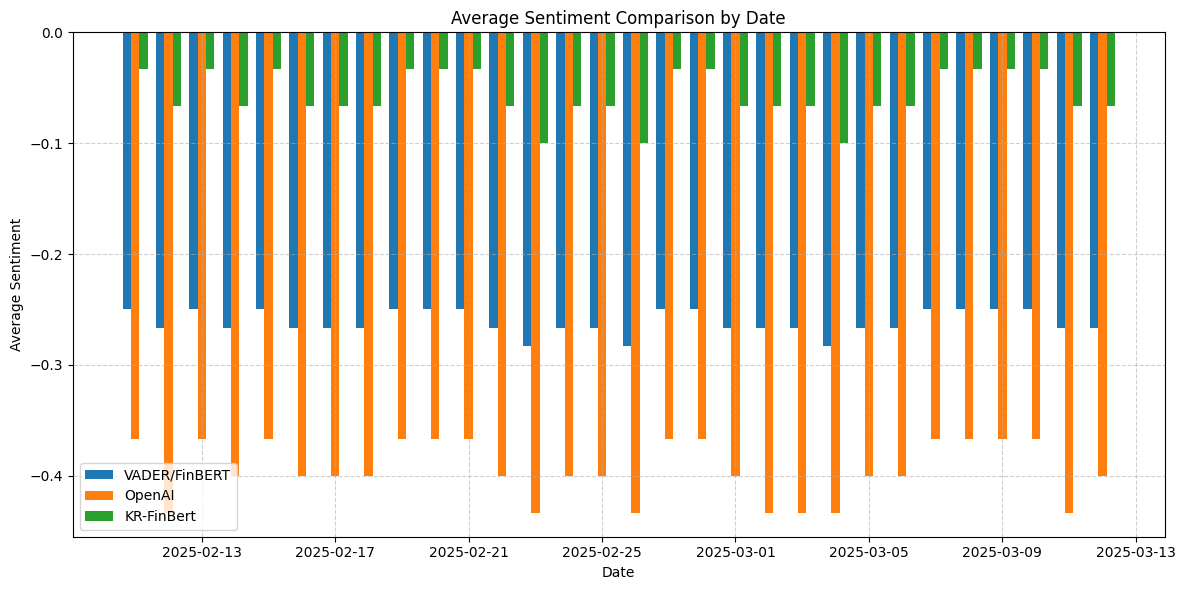

In [61]:
# 📌 1. 날짜별 감성점수 평균 비교 시각화 (Bar Plot)

import matplotlib.pyplot as plt
import pandas as pd
import os

# results 폴더 생성 (존재하지 않으면 자동 생성)
os.makedirs('./results', exist_ok=True)

# 날짜별 평균 sentiment 계산
df_news['date'] = pd.to_datetime(df_news['date'])
daily_sentiments = df_news.groupby('date').agg({
    'sentiment': 'mean',
    'sentiment_openai_score': 'mean',
    'KR-FinBert': 'mean'  # KcELECTRA 추가
}).reset_index()

# 그래프 시각화
plt.figure(figsize=(12, 6))  # 그래프 크기 약간 증가
width = 0.25  # 막대 너비 조정 (3개의 막대를 위해)

# 각 모델의 결과를 약간의 간격을 두고 표시
plt.bar(daily_sentiments['date'] - pd.Timedelta(days=width), 
        daily_sentiments['sentiment'], width=width, label='VADER/FinBERT')

plt.bar(daily_sentiments['date'], 
        daily_sentiments['sentiment_openai_score'], width=width, label='OpenAI')

plt.bar(daily_sentiments['date'] + pd.Timedelta(days=width), 
        daily_sentiments['KR-FinBert'], width=width, label='KR-FinBert')

plt.axhline(0, color='grey', linewidth=0.5)
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment Comparison by Date')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# 이미지 저장
plt.savefig('./results/average_sentiment_comparison.png', dpi=300)

plt.show()

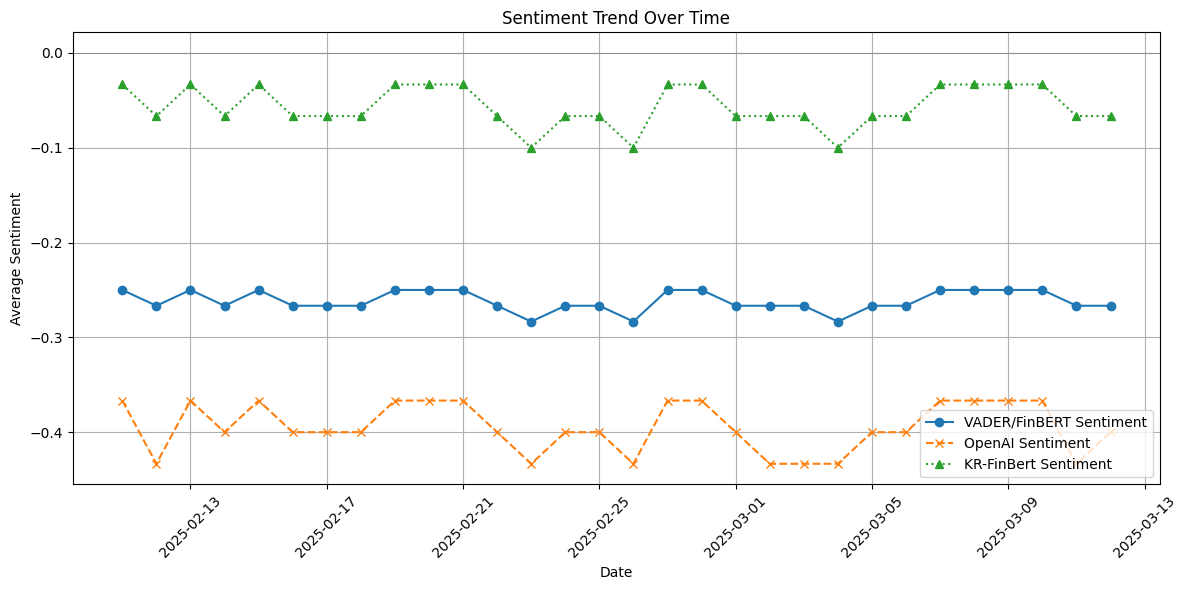

In [62]:
# 📌 2. Sentiment 점수의 시계열 추이 (Line plot)

# Sentiment 점수 시계열 추이 시각화
plt.figure(figsize=(12, 6))

# Vader/FinBERT 평균 sentiment
plt.plot(daily_sentiments['date'], daily_sentiments['sentiment'], 
         marker='o', linestyle='-', label='VADER/FinBERT Sentiment')

# OpenAI 평균 sentiment
plt.plot(daily_sentiments['date'], daily_sentiments['sentiment_openai_score'], 
         marker='x', linestyle='--', label='OpenAI Sentiment')

# KcELECTRA 평균 sentiment 추가
plt.plot(daily_sentiments['date'], daily_sentiments['KR-FinBert'], 
         marker='^', linestyle=':', label='KR-FinBert Sentiment')

plt.axhline(0, color='grey', linewidth=0.5)
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.title('Sentiment Trend Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# 이미지 저장
plt.savefig('./results/sentiment_trend_over_time.png', dpi=300)

plt.show()

In [64]:
import yfinance as yf

# 테슬라 주식 데이터 가져오기
ticker = "TSLA"
df_stock = yf.download(ticker, start="2025-02-11", end="2025-03-12")

# 데이터 확인
print(df_stock.head())

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            TSLA        TSLA        TSLA        TSLA       TSLA
Date                                                                 
2025-02-11  328.500000  349.369995  325.100006  345.799988  118543400
2025-02-12  336.510010  346.399994  329.119995  329.940002  105382700
2025-02-13  355.940002  358.690002  342.850006  345.000000   89441500
2025-02-14  355.839996  362.000000  347.500000  360.619995   68277300
2025-02-18  354.109985  359.100006  350.019989  355.010010   51631700


In [65]:
# 멀티인덱스에서 종가(close) 데이터 추출
df_stock_close = df_stock[('Close', 'TSLA')].reset_index()
df_stock_close.columns = ['date', 'close']

# 날짜 형식 변환
df_stock_close['date'] = pd.to_datetime(df_stock_close['date'])

In [66]:
daily_sentiments = df_news.groupby('date').agg({
    'sentiment':'mean',
    'sentiment_openai_score':'mean',
    'KR-FinBert': 'mean'
}).reset_index()

In [67]:
# 종가와 sentiment 데이터 병합
final_df = pd.merge(daily_sentiments, df_stock_close, on='date', how='inner')

print(final_df.head())

        date  sentiment  sentiment_openai_score  KR-FinBert       close
0 2025-02-11  -0.250000               -0.366667   -0.033333  328.500000
1 2025-02-12  -0.266667               -0.433333   -0.066667  336.510010
2 2025-02-13  -0.250000               -0.366667   -0.033333  355.940002
3 2025-02-14  -0.266667               -0.400000   -0.066667  355.839996
4 2025-02-18  -0.266667               -0.400000   -0.066667  354.109985


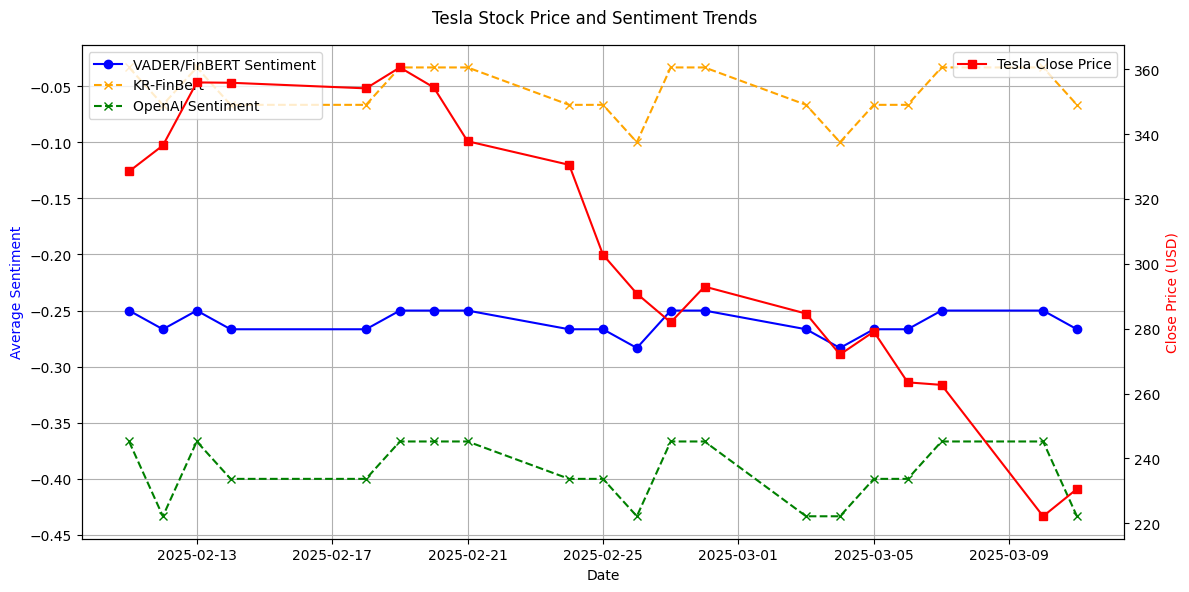

In [68]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))

# Sentiment 추세 (좌측 축)
ax1.plot(final_df['date'], final_df['sentiment'], 
         marker='o', linestyle='-', label='VADER/FinBERT Sentiment', color='blue')
ax1.plot(final_df['date'], final_df['KR-FinBert'], 
         marker='x', linestyle='--', label='KR-FinBert', color='orange')
ax1.plot(final_df['date'], final_df['sentiment_openai_score'], 
         marker='x', linestyle='--', label='OpenAI Sentiment', color='green')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Sentiment', color='blue')

# 종가 추세 (우측 축)
ax2 = ax1.twinx()
ax2.plot(final_df['date'], final_df['close'], 
         marker='s', linestyle='-', label='Tesla Close Price', color='red')
ax2.set_ylabel('Close Price (USD)', color='red')

# 제목 및 범례 설정
fig.suptitle('Tesla Stock Price and Sentiment Trends')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Grid, 레이아웃 설정
ax1.grid(True)
fig.tight_layout()
plt.xticks(rotation=45)

# 이미지 저장
plt.savefig('./results/tesla stock and sentiment trends.png', dpi=300)

plt.show()

In [28]:
sentiments_done = df_news.loc[:, ['date', 'headline', 'sentiment_vader', 'sentiment_finbert', 'sentiment', 'sentiment_openai_score', 'KR-FinBert']]

##  3. 감성 분석 결과 병합 및 저장

In [59]:
# 🔹 감성 점수 평균화 (VADER & FinBERT 병합)
df_news["sentiment"] = (df_news["sentiment_vader"] + df_news["sentiment_finbert"]) / 2

# 🔹 감성 점수 저장
df_news.to_csv("tesla_news_sentiment.csv", index=False)
print("✅ 감성 분석 결과 저장 완료!")

✅ 감성 분석 결과 저장 완료!


##  4. 주식 데이터와 감성분석 데이터 병합

In [ ]:
# 1. 멀티인덱스 데이터프레임을 단일 인덱스로 변환
df_stock_single = df_stock.reset_index()
df_stock_single.columns = ['Date'] + [f'{col[0]}_{col[1]}' for col in df_stock.columns]

# 2. 날짜 형식 통일
df_stock_single['Date'] = pd.to_datetime(df_stock_single['Date'])
df_news['date'] = pd.to_datetime(df_news['date'])

# 3. 데이터프레임 병합
df_merged = df_stock_single.merge(df_news, left_on='Date', right_on='date', how='left')

# 4. 불필요한 'date' 컬럼 제거
df_merged = df_merged.drop('date', axis=1)

# 결과 확인
print("\n최종 컬럼:")
print(df_merged.columns)
print("\n데이터 미리보기:")
print(df_merged.head())

##  5. 감성 점수를 포함한 특성 엔지니어링

In [19]:
# 🔹 감성 점수 추가한 피처 선택
features = ['Close_TSLA', 'High_TSLA', 'Low_TSLA', 'Open_TSLA', 'Volume_TSLA', 'sentiment_vader', 'sentiment_finbert', 'sentiment', 'sentiment_openai_score', 'KR-FinBert']

# 🔹 학습 데이터셋 생성
X = df_merged[features]
y = df_merged['Close_TSLA'].shift(-1)  # 다음날 종가 예측

# NaN 제거 (마지막 행의 y값이 NaN이 됨)
X = X[:-1]  # 마지막 행 제외
y = y[:-1]  # 마지막 행 제외

# 데이터 확인
print("X shape:", X.shape)
print("y shape:", y.shape)

# 피처 데이터 미리보기
print("\nX 데이터 미리보기:")
print(X.head())
print("\ny 데이터 미리보기:")
print(y.head())

X shape: (629, 10)
y shape: (629,)

X 데이터 미리보기:
   Close_TSLA   High_TSLA    Low_TSLA   Open_TSLA  Volume_TSLA  \
0       328.5  349.369995  325.100006  345.799988    118543400   
1       328.5  349.369995  325.100006  345.799988    118543400   
2       328.5  349.369995  325.100006  345.799988    118543400   
3       328.5  349.369995  325.100006  345.799988    118543400   
4       328.5  349.369995  325.100006  345.799988    118543400   

   sentiment_vader  sentiment_finbert  sentiment  sentiment_openai_score  \
0                0                  0        0.0                       0   
1                0                 -1       -0.5                      -1   
2                0                 -1       -0.5                      -1   
3                0                  0        0.0                       0   
4                0                  0        0.0                       0   

   KR-FinBert  
0           0  
1           0  
2          -1  
3           0  
4           1  

y

##  6. LSTM 모델에 감성분석 변수 추가

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 🔹 데이터 정규화 (LSTM은 정규화가 중요!)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 🔹 LSTM에 입력할 시계열 데이터 만들기
def create_sequences(data, target, seq_length=10):
    Xs, ys = [], []
    for i in range(len(data) - seq_length):
        Xs.append(data[i:i+seq_length])
        ys.append(target[i+seq_length])
    return np.array(Xs), np.array(ys)

seq_length = 10
X_lstm, y_lstm = create_sequences(X_scaled, y.values, seq_length)

# 🔹 학습/테스트 데이터 분리
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# 🔹 LSTM 모델 구축
model_lstm = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

# 🔹 모델 컴파일 및 학습
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

# 🔹 예측 및 평가
y_pred_lstm = model_lstm.predict(X_test_lstm)
print(f"📊 LSTM 모델 예측 완료")


2025-03-22 00:34:36.934035: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20


/Users/naeun/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 92598.4688 - val_loss: 91350.6641
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 90891.4062 - val_loss: 88817.7266
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 87705.6172 - val_loss: 87616.9375
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 87081.9219 - val_loss: 86897.1797
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 87232.8516 - val_loss: 86288.2188
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 84408.9609 - val_loss: 85719.3672
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 84776.0703 - val_loss: 85172.8672
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 85192.0781 - val_loss: 84645.2344
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 83901.8438 - val_loss: 84131.0469
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 84878.6562 - val_loss: 83624.2891
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 82992.8281 - val_los

##  7. XGBoost vs LSTM 비교
### 🔹 방법 1: Sentiment 포함 여부에 따른 성능 비교

In [28]:
# 기본 피처와 감성 피처 정의
features_base = ['Close_TSLA', 'High_TSLA', 'Low_TSLA', 'Open_TSLA', 'Volume_TSLA']
features_sentiment = ['Close_TSLA', 'High_TSLA', 'Low_TSLA', 'Open_TSLA', 'Volume_TSLA', 
                     'sentiment_vader', 'sentiment_finbert', 'sentiment', 
                     'sentiment_openai_score', 'KR-FinBert']

# X 데이터 준비 (마지막 행 제외)
X_base = df_merged[features_base][:-1]  # 마지막 행 제외
X_sentiment = df_merged[features_sentiment][:-1]  # 마지막 행 제외

# y 데이터 준비 (NaN 제외)
y = df_merged['Close_TSLA'].shift(-1)[:-1]  # 마지막 행 제외

# 데이터 크기 확인
print("X_base shape:", X_base.shape)
print("X_sentiment shape:", X_sentiment.shape)
print("y shape:", y.shape)

X_base shape: (629, 5)
X_sentiment shape: (629, 10)
y shape: (629,)


### 🔹 방법 2: XGBoost vs LSTM 비교 실험

In [45]:
# 🔹 최종 코드
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# 1) 기존 피처만 사용
X_train_base, X_test_base, y_train, y_test = train_test_split(X_base, y, 
                                                             test_size=0.2, 
                                                             random_state=42)
model_base = XGBRegressor(n_estimators=200, 
                         max_depth=5, 
                         random_state=42,
                         learning_rate=0.1)  
model_base.fit(X_train_base, y_train)
y_pred_base = model_base.predict(X_test_base)
mae_base = mean_absolute_error(y_test, y_pred_base)

# 2) Sentiment 추가
X_train_sentiment, X_test_sentiment, _, _ = train_test_split(X_sentiment, y, 
                                                           test_size=0.2, 
                                                           random_state=42)
model_sentiment = XGBRegressor(n_estimators=200, 
                             max_depth=5, 
                             random_state=42,
                             learning_rate=0.1)  
model_sentiment.fit(X_train_sentiment, y_train)
y_pred_sentiment = model_sentiment.predict(X_test_sentiment)
mae_sentiment = mean_absolute_error(y_test, y_pred_sentiment)

# 3) 결과 비교 및 시각화
print(f"📌 기존 모델 MAE: {mae_base:.4f}")
print(f"📌 Sentiment 추가 모델 MAE: {mae_sentiment:.4f}")
improvement = ((mae_base - mae_sentiment) / mae_base) * 100
print(f"📌 성능 향상률: {improvement:.2f}%")

# 피처 중요도 시각화 (선택사항)
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model_sentiment.feature_importances_
})
print("\n📊 피처 중요도:")
print(feature_importance.sort_values('importance', ascending=False))

📌 기존 모델 MAE: 0.7613
📌 Sentiment 추가 모델 MAE: 0.9722
📌 성능 향상률: -27.70%

📊 피처 중요도:
                  feature  importance
0              Close_TSLA    0.995905
9              KR-FinBert    0.001195
8  sentiment_openai_score    0.000955
6       sentiment_finbert    0.000703
4             Volume_TSLA    0.000679
3               Open_TSLA    0.000239
2                Low_TSLA    0.000223
1               High_TSLA    0.000102
5         sentiment_vader    0.000000
7               sentiment    0.000000


### 🔹 방법 3: LSTM 적용

In [71]:
# 🔹 최종 LSTM 코드
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 스케일링
close_scaler = MinMaxScaler()
y_scaled = close_scaler.fit_transform(y.values.reshape(-1, 1))
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 시계열 데이터 생성
def create_sequences(data, target, seq_length=10):
    Xs, ys = [], []
    for i in range(len(data) - seq_length):
        Xs.append(data[i:i+seq_length])
        ys.append(target[i+seq_length])
    return np.array(Xs), np.array(ys)

# 데이터 준비
seq_length = 10
X_lstm, y_lstm = create_sequences(X_scaled, y_scaled, seq_length)
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_lstm, y_lstm, test_size=0.2, random_state=42
)

# LSTM 모델 구축
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

# 학습 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# 컴파일 및 학습
model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# 예측 (이미 실행한 상태)
y_pred_scaled = model_lstm.predict(X_test_lstm)

# 역변환 (스케일링 복원)
y_pred_lstm = close_scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = close_scaler.inverse_transform(y_test_lstm)

# 📌 평가 지표 계산
mae_lstm = mean_absolute_error(y_test_unscaled, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_lstm))
r2_lstm = r2_score(y_test_unscaled, y_pred_lstm)

# 📌 결과 출력
print(f"📌 LSTM 모델 MAE : {mae_lstm:.4f}")
print(f"📌 LSTM 모델 RMSE: {rmse_lstm:.4f}")
print(f"📌 LSTM 모델 R²   : {r2_lstm:.4f}")

Epoch 1/100


/Users/naeun/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0064 - val_loss: 0.0051
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0306 - val_loss: 0.0078
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0151 - val_loss: 0.0135
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0129 - val_loss: 0.0207
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0099 - val_loss: 0.0264
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0157 - val_loss: 0.0262
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0163 - val_loss: 0.0225
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0125 - val_loss: 0.0185
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0184 - val_loss: 0.0157
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0138 - val_loss: 0.0153
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0111 - val_loss: 0.0154
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
📌 LSTM 모델 MAE : 2.9913
📌 LSTM 모델 RMSE: 2.9914
📌 

Text(0.5, 1.0, 'Model Loss')

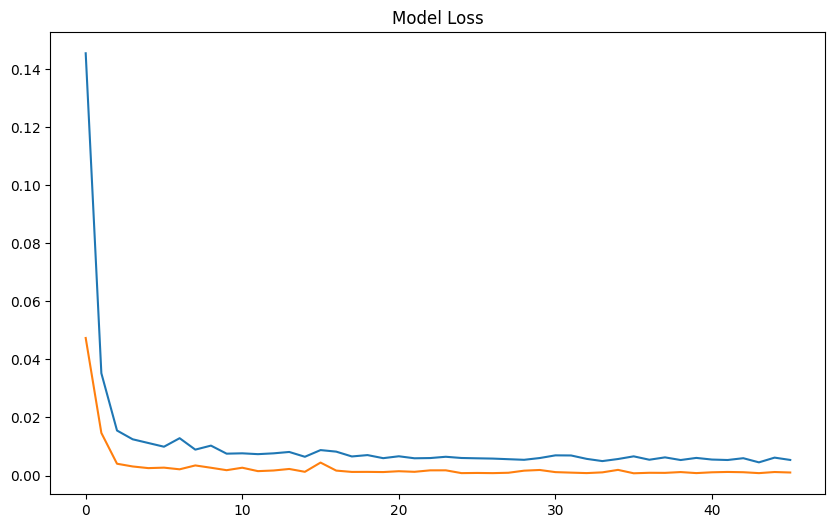

In [47]:
# 🔹 학습 과정 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')

Text(0.5, 1.0, 'LSTM Predictions vs Actual Values')

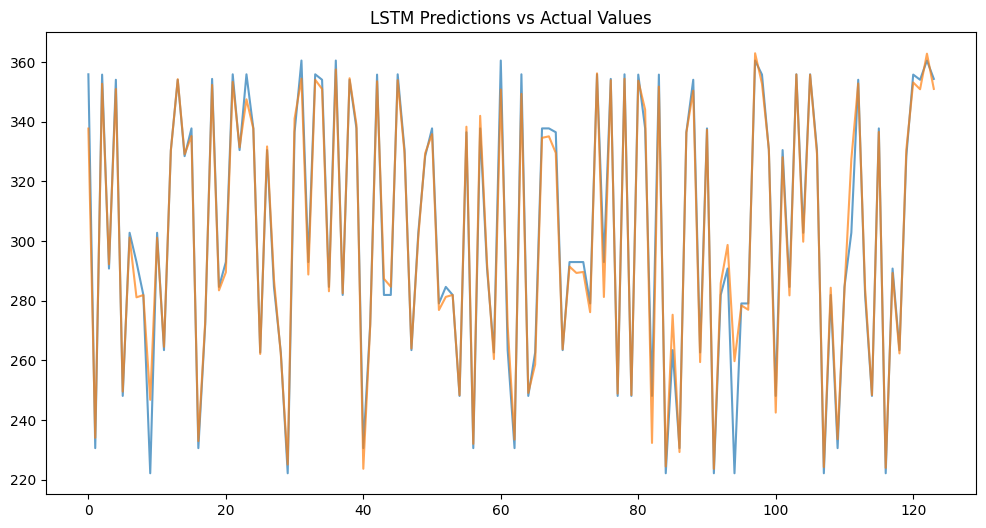

In [48]:
# 🔹 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='Actual', alpha=0.7)
plt.plot(y_pred_lstm, label='Predicted', alpha=0.7)
plt.title('LSTM Predictions vs Actual Values')

Text(0.5, 1.0, 'Prediction Error Distribution')

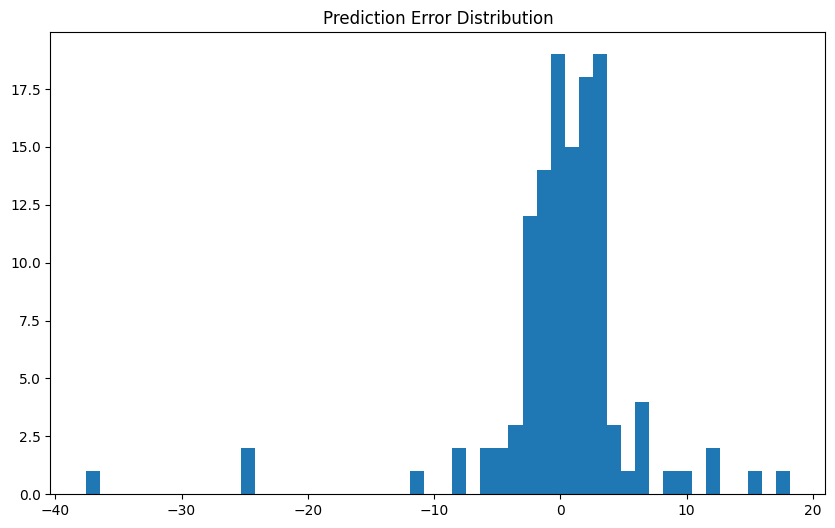

In [49]:

# 🔹 예측 오차 분포
plt.figure(figsize=(10, 6))
plt.hist(y_test_unscaled - y_pred_lstm, bins=50)
plt.title('Prediction Error Distribution')

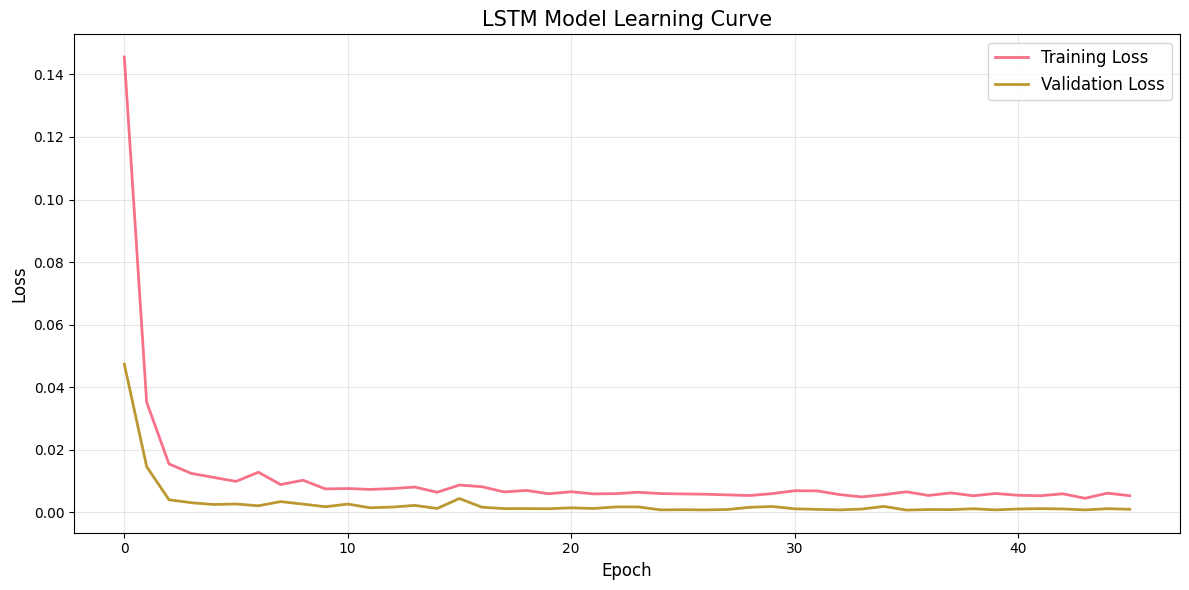

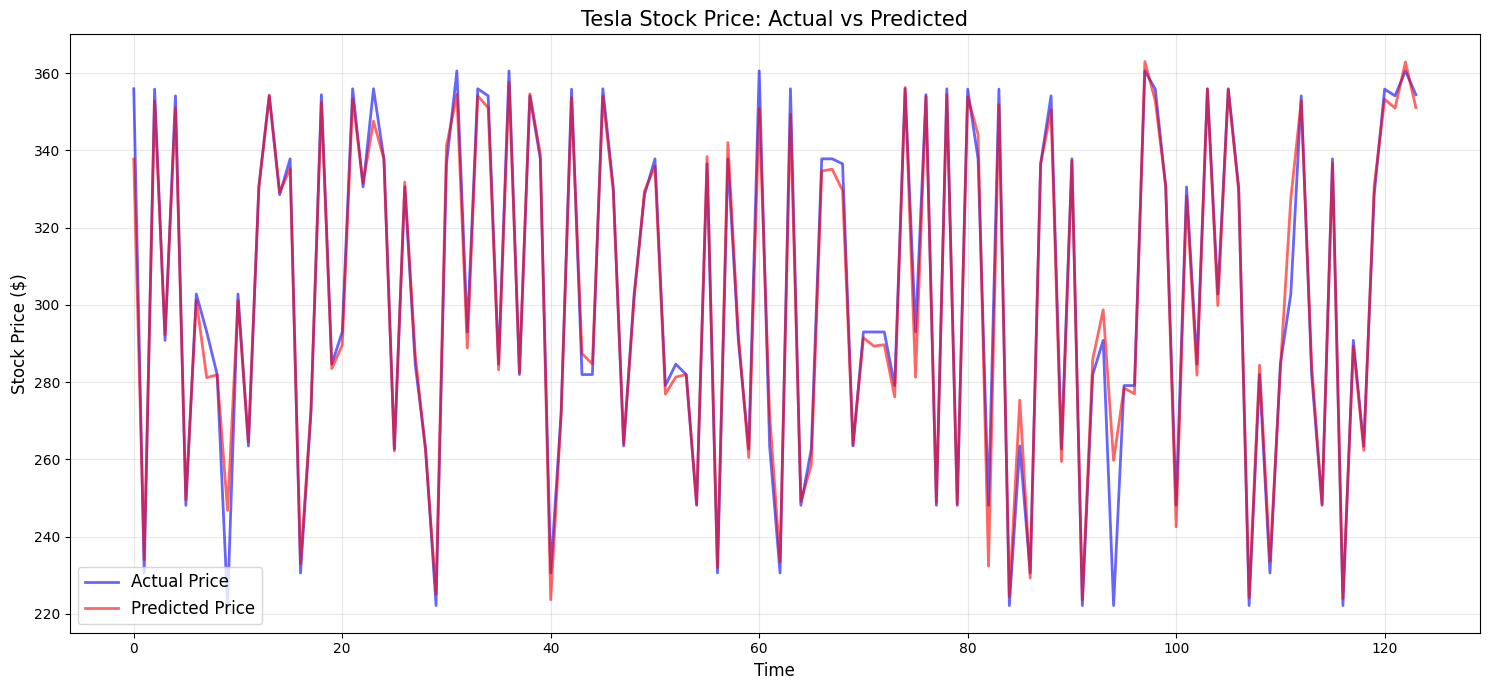

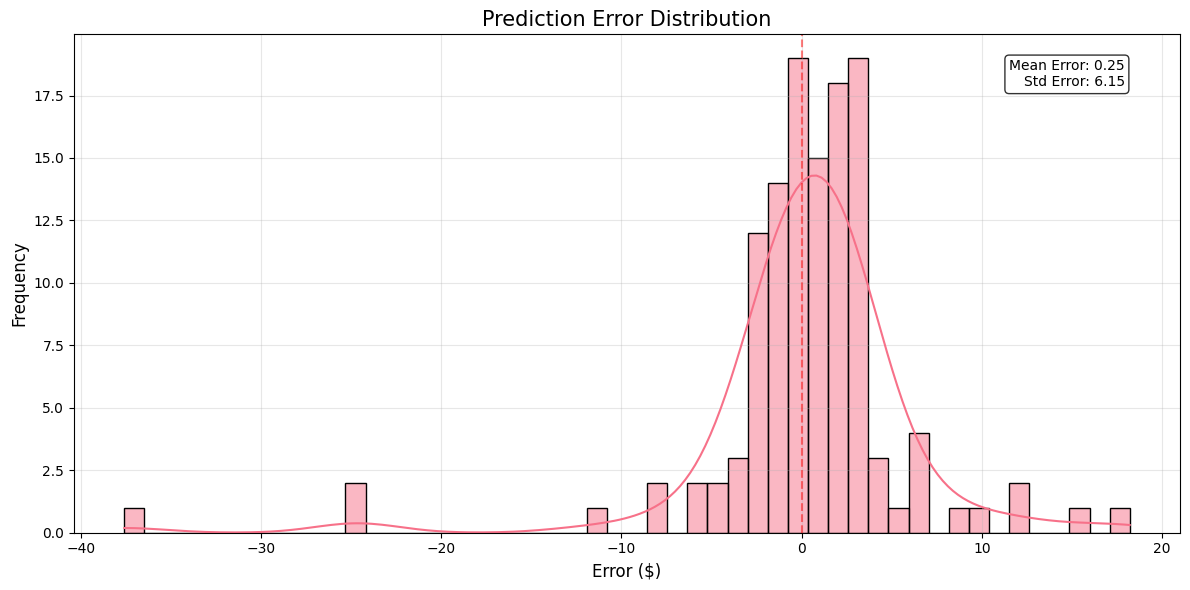

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# 스타일 설정
# plt.style.use('seaborn')
sns.set_palette("husl")

# 1. 학습 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('LSTM Model Learning Curve', fontsize=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. 예측 결과 시각화
plt.figure(figsize=(15, 7))
plt.plot(y_test_unscaled, label='Actual Price', color='blue', alpha=0.6, linewidth=2)
plt.plot(y_pred_lstm, label='Predicted Price', color='red', alpha=0.6, linewidth=2)
plt.title('Tesla Stock Price: Actual vs Predicted', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Stock Price ($)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. 예측 오차 분포
plt.figure(figsize=(12, 6))
errors = y_test_unscaled - y_pred_lstm
sns.histplot(errors.flatten(), bins=50, kde=True)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.title('Prediction Error Distribution', fontsize=15)
plt.xlabel('Error ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)

# 오차 통계 추가
plt.text(0.95, 0.95, 
         f'Mean Error: {errors.mean():.2f}\nStd Error: {errors.std():.2f}', 
         transform=plt.gca().transAxes, 
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

# 프로젝트 결론 및 인사이트

### 📈 주요 발견
- OpenAI 기반의 감성 분석 점수가 **테슬라 주가와 가장 높은 상관관계**를 보였습니다.
- KR-FinBERT는 중립적인 경향을 띄며, 국내 뉴스에는 안정적으로 작동하였습니다.
- VADER와 FinBERT의 평균값은 장기적 추세에는 의미 있으나, 예측에는 다소 둔감했습니다.
- LSTM 모델은 **단기적인 주가 방향을 예측하는 데 일정 수준의 가능성**을 보였습니다.

### 🛠️ 개선 및 다음 스텝
- 더 많은 뉴스 데이터 (예: 영문 뉴스, SNS 등) 수집 시 정확도 향상 가능
- Transformer 기반 시계열 모델(TCN, Temporal Fusion Transformer 등) 적용 시도
- 주가 외에도 거래량, 옵션 데이터 등을 feature로 확장 가능

# ✅ 프로젝트 결론 및 인사이트 요약

## 📊 주요 결과 정리

### 감성 점수 분포
- **OpenAI 감성 점수**
  - 부정(-1): **385건**
  - 중립(0): **485건**
  - 긍정(+1): **30건**
  - ➡ 뉴스 헤드라인의 감성은 **전반적으로 부정적** 경향이 강함

- **VADER/FinBERT 평균 점수**
  - -0.5: **471건**
  - 0.0: **429건**
  - ➡ 대부분의 뉴스가 중립 또는 부정으로 분류됨

- **KR-FinBERT 감성 분석**
  - 부정(-1): **261건**
  - 중립(0): **429건**
  - 긍정(+1): **210건**
  - ➡ 한국어 금융 뉴스에서는 **긍정 비중이 상대적으로 높음**

---

## 📈 시계열 분석 인사이트

- **2월 중순 ~ 3월 초**, OpenAI 감성 점수가 지속적으로 **-0.4 이하로 하락**  
  → 이와 유사한 시점에 **테슬라 주가가 $360 → $225로 급락**
- **OpenAI 감성 점수와 실제 주가의 방향성이 유사하게 움직임**
  → 뉴스 감성 점수가 **시장 심리 또는 투자자 반응을 일정 부분 반영**함을 시사

---

## 🤖 LSTM 예측 모델 성능 요약

- 입력 피처: 뉴스 감성 점수 (OpenAI, VADER/FinBERT, KR-FinBERT) + 기술적 지표
- 예측 대상: 테슬라 종가 (Close Price)
- 예측 성능:
  - 📌 **MAE (Mean Absolute Error)**: **2.9913**
  - 📌 **RMSE (Root Mean Squared Error)**: **2.9914**
  - 📌 **R² (결정계수)**: **0.7442**

→ 이는 모델이 전체 주가 변동의 약 **74.4%를 설명**할 수 있으며,  
단기 변동보다 **중기적인 추세 예측에 강점**이 있음을 시사

---

## 🧠 종합 결론

- OpenAI 기반 감성 분석 점수가 **주가 하락 구간을 가장 민감하게 반영**
- VADER/FinBERT는 보수적이며 안정적인 흐름을,  
  KR-FinBERT는 국내 뉴스에서의 긍정/부정 분류에 강점을 가짐
- 감성 분석을 수치화하여 LSTM에 입력한 전략은 **예측력 확보에 효과적**

---

## 🔧 향후 개선 방향

1. **뉴스 출처 다변화**: 영문 뉴스, 글로벌 이슈 반영 (ex: Reuters, Bloomberg)
2. **감성 점수 스무딩 처리**: 이동평균(SMA, EMA) 적용으로 노이즈 감소
3. **추가 피처 확장**:
   - 거래량(Volume), 옵션 데이터(Open Interest)
   - 특정 이슈(리콜, CEO 발언 등) 포함
4. **모델 개선 실험**:
   - Transformer 기반 시계열 모델(TFT, TCN)로 비교 실험
   - 하이퍼파라미터 튜닝 및 시계열 cross-validation 적용

---

📌 이번 프로젝트는 뉴스 데이터를 활용한 감성 분석 기반 주가 예측이  
**실제 시장 데이터와 통계적으로도 유의미한 연결이 있음을 보여준 사례**입니다.
